# Trying one last tuning

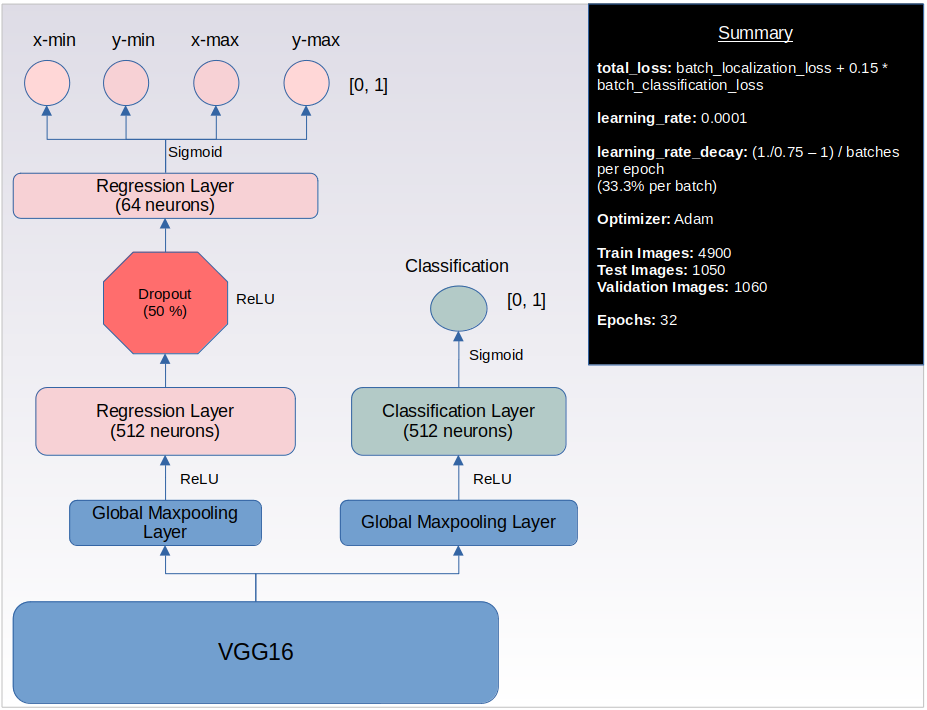

In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import os
import json
import shutil
import random
import fnmatch
from pprint import pprint
from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalMaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

2023-12-07 16:38:30.584535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Might as well check, because this can be a mess...
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow:", tf.__version__)
print("Numpy:", np.__version__)

# Apparently prevents out-of-memory errors
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  2
Tensorflow: 2.4.1
Numpy: 1.23.5


2023-12-07 16:38:31.966720: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-07 16:38:31.967754: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-07 16:38:32.028190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-07 16:38:32.028421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 20 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 298.32GiB/s
2023-12-07 16:38:32.028439: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so

In [3]:
keras.backend.clear_session()

In [4]:
def load_annotations(annot_path):
    with open(annot_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
        
        # Grab only first label["coords"]
    return [label["class"]], label["coords"]


train_labels = tf.data.Dataset.list_files("./pipeline-data/train-transformed/annotations/*json", 
                                          shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))


test_labels = tf.data.Dataset.list_files("./pipeline-data/test-transformed/annotations/*json", 
                                          shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))


val_labels = tf.data.Dataset.list_files("./pipeline-data/val-transformed/annotations/*json", 
                                          shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_annotations, [x], [tf.uint8, tf.float16]))

2023-12-07 16:38:32.070233: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:38:32.073976: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-07 16:38:32.272570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.635GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-12-07 16:38:32.272824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock

In [5]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_image)
    return image

In [6]:
train_images = tf.data.Dataset.list_files("./pipeline-data/train-transformed/images/*jpg", shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (256, 256)))
train_images = train_images.map(lambda x : x/255)

test_images = tf.data.Dataset.list_files("./pipeline-data/test-transformed/images/*jpg", shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (256, 256)))
test_images = test_images.map(lambda x : x/255)

val_images = tf.data.Dataset.list_files("./pipeline-data/val-transformed/images/*jpg", shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (256, 256)))
val_images = val_images.map(lambda x : x/255)

print("Train:", len(train_images), len(train_labels))
print("Test:", len(test_images), len(test_labels))
print("Val:", len(val_images), len(val_labels))

Train: 4900 4900
Test: 1050 1050
Val: 1060 1060


In [7]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1100)
test = test.batch(32)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1100)
val = val.batch(32)
val = val.prefetch(4)

In [8]:
def build_model():
    
    input_layer = Input(shape = (256, 256, 3))
    # Using VGG16 here
    vgg16 = VGG16(include_top = False)(input_layer)
    
    
    # ============= Classification =======================================================
    condensing_layer_1 = GlobalMaxPooling2D()(vgg16)
    classification_layer_1 = Dense(512, activation = "relu")(condensing_layer_1)
    classification_output_layer = Dense(1, activation = "sigmoid")(classification_layer_1)
    
    
    # ============= Bounding Box Regression ==============================================
    condensing_layer_2 = GlobalMaxPooling2D()(vgg16)
    regression_layer_1 = Dense(512, activation = "relu")(condensing_layer_2)
    dropout_layer_1 = Dropout(0.5)(regression_layer_1)
    regression_layer_2 = Dense(64, activation = "relu")(dropout_layer_1)
    regression_output_layer = Dense(4, activation = "sigmoid")(regression_layer_2)
    
    
    
    myModel = Model(inputs = input_layer, outputs = [classification_output_layer, regression_output_layer])
    myModel.build(input_shape = (None, 256, 256, 3))
    return myModel

In [9]:
class FaceLocalizer3(Model):
    def __init__(self, myModel, **kwargs):
        super().__init__(**kwargs)
        self.model = myModel
        
    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss
        self.optimizer = optimizer
    
    # One batch at a time, of course
    def train_step(self, batch, **kwargs):
        # X = image
        # y = labels
        # y[0] = classes, y[1] = bounding box coordinates
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction from the model by passing through an image
            classes, coords = self.model(X, training = True)
            
            # Calculate losses
            batch_classification_loss = self.classification_loss(y[0], classes)
            batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
            
            # Could change how this is calculated - Chagning it from 0.5 to 0.15, making it "matter" even less
            total_loss = batch_localization_loss + 0.15 * batch_classification_loss
            
            gradient = tape.gradient(total_loss, self.model.trainable_variables)
            
        # This is actually the back propagation
        optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self.model(X, training = False)
        
        batch_classification_loss = self.classification_loss(y[0], classes)
        batch_localization_loss = self.localization_loss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localization_loss + 0.15 * batch_classification_loss
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "localization_loss": batch_localization_loss}
        
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [10]:
def localization_loss(y_true, y_predicted):
    
    delta_coords = tf.reduce_sum(tf.square(y_true[:,:2] - y_predicted[:,:2]))
    # print("delta_coords = ", delta_coords)
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    # print("h_true = ", h_true)
    # print("w_true = ", w_true)
    
    h_predicted = y_predicted[:,3] - y_predicted[:,1]
    w_predicted = y_predicted[:,2] - y_predicted[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_predicted) + tf.square(h_true - h_predicted))
    
    return delta_coords + delta_size


classification_loss = tf.keras.losses.BinaryCrossentropy()
localization_loss = localization_loss

batches_per_epoch = len(train)
learning_rate_decay = (1. / 0.75 - 1)/batches_per_epoch
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = learning_rate_decay)

In [11]:
newModel = build_model()
newModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      global_max_pooling2d_1[0][0]     
______________________________________________________________________________________________

In [12]:
model_tuned = FaceLocalizer3(newModel)

In [13]:
model_tuned.compile(optimizer, 
              classification_loss = classification_loss, 
              localization_loss = localization_loss)

In [14]:
%%time
history = model_tuned.fit(train, 
                    validation_data = val, 
                    epochs = 32)

Epoch 1/32


2023-12-07 16:38:34.703478: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-07 16:38:34.712829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3099995000 Hz
2023-12-07 16:38:34.933175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-12-07 16:38:44.923926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2898 of 5000
2023-12-07 16:38:51.340772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
2023-12-07 16:38:51.396077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-12-07 16:38:52.584733: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-12-07 16:38:52.812635: W tensorflow/stream_executor/gpu/redz

154/154 [==============================] - 179s 611ms/step - total_loss: 4.0959 - classification_loss: 0.2053 - localization_loss: 4.0651 - val_total_loss: 0.1448 - val_classification_loss: 0.0106 - val_localization_loss: 0.1432
Epoch 2/32


2023-12-07 16:41:42.716831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3156 of 5000
2023-12-07 16:41:49.083096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 247ms/step - total_loss: 0.9607 - classification_loss: 0.0164 - localization_loss: 0.9583 - val_total_loss: 0.0239 - val_classification_loss: 0.0071 - val_localization_loss: 0.0228
Epoch 3/32


2023-12-07 16:42:37.140415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2951 of 5000
2023-12-07 16:42:43.968082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 245ms/step - total_loss: 0.7174 - classification_loss: 0.0116 - localization_loss: 0.7156 - val_total_loss: 0.0126 - val_classification_loss: 0.0018 - val_localization_loss: 0.0124
Epoch 4/32


2023-12-07 16:43:31.715486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3687 of 5000
2023-12-07 16:43:34.320897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 251ms/step - total_loss: 0.4726 - classification_loss: 0.0028 - localization_loss: 0.4722 - val_total_loss: 0.0284 - val_classification_loss: 0.0035 - val_localization_loss: 0.0279
Epoch 5/32


2023-12-07 16:44:22.970294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3608 of 5000
2023-12-07 16:44:27.113359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 240ms/step - total_loss: 0.4116 - classification_loss: 0.0011 - localization_loss: 0.4115 - val_total_loss: 0.1017 - val_classification_loss: 8.0350e-04 - val_localization_loss: 0.1016
Epoch 6/32


2023-12-07 16:45:14.053898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3106 of 5000
2023-12-07 16:45:21.283592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 244ms/step - total_loss: 0.3904 - classification_loss: 0.0015 - localization_loss: 0.3902 - val_total_loss: 0.0100 - val_classification_loss: 9.9478e-05 - val_localization_loss: 0.0100
Epoch 7/32


2023-12-07 16:46:08.918217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3241 of 5000
2023-12-07 16:46:14.132004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 244ms/step - total_loss: 0.3369 - classification_loss: 6.3111e-04 - localization_loss: 0.3368 - val_total_loss: 0.0309 - val_classification_loss: 3.3372e-04 - val_localization_loss: 0.0308
Epoch 8/32


2023-12-07 16:47:01.737067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4304 of 5000
2023-12-07 16:47:03.530977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 253ms/step - total_loss: 0.3168 - classification_loss: 3.5170e-04 - localization_loss: 0.3168 - val_total_loss: 0.0384 - val_classification_loss: 3.8774e-05 - val_localization_loss: 0.0384
Epoch 9/32


2023-12-07 16:47:52.449657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3124 of 5000
2023-12-07 16:47:58.564552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 255ms/step - total_loss: 0.2972 - classification_loss: 3.2357e-04 - localization_loss: 0.2972 - val_total_loss: 0.0095 - val_classification_loss: 2.0900e-04 - val_localization_loss: 0.0094
Epoch 10/32


2023-12-07 16:48:47.905545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 4316 of 5000
2023-12-07 16:48:48.974480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 49s 248ms/step - total_loss: 0.2896 - classification_loss: 2.4522e-04 - localization_loss: 0.2896 - val_total_loss: 3.9709e-04 - val_classification_loss: 5.4537e-04 - val_localization_loss: 3.1528e-04
Epoch 11/32


2023-12-07 16:49:37.180332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3594 of 5000
2023-12-07 16:49:40.333937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 254ms/step - total_loss: 0.2721 - classification_loss: 2.5109e-04 - localization_loss: 0.2720 - val_total_loss: 0.0166 - val_classification_loss: 0.0014 - val_localization_loss: 0.0164
Epoch 12/32


2023-12-07 16:50:29.463685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3185 of 5000
2023-12-07 16:50:33.488353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 251ms/step - total_loss: 0.2633 - classification_loss: 2.2949e-04 - localization_loss: 0.2632 - val_total_loss: 0.0105 - val_classification_loss: 6.3874e-05 - val_localization_loss: 0.0105
Epoch 13/32


2023-12-07 16:51:22.245447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2762 of 5000
2023-12-07 16:51:29.555660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 56s 254ms/step - total_loss: 0.2520 - classification_loss: 1.9621e-04 - localization_loss: 0.2520 - val_total_loss: 0.1483 - val_classification_loss: 5.8447e-04 - val_localization_loss: 0.1483
Epoch 14/32


2023-12-07 16:52:18.691685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3308 of 5000
2023-12-07 16:52:24.143564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 250ms/step - total_loss: 0.2490 - classification_loss: 1.8243e-04 - localization_loss: 0.2490 - val_total_loss: 0.0361 - val_classification_loss: 2.1318e-04 - val_localization_loss: 0.0360
Epoch 15/32


2023-12-07 16:53:12.664206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3009 of 5000
2023-12-07 16:53:17.367740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 251ms/step - total_loss: 0.2279 - classification_loss: 1.3392e-04 - localization_loss: 0.2279 - val_total_loss: 0.0115 - val_classification_loss: 0.0018 - val_localization_loss: 0.0112
Epoch 16/32


2023-12-07 16:54:06.035067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3345 of 5000
2023-12-07 16:54:11.232447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.2276 - classification_loss: 1.1449e-04 - localization_loss: 0.2275 - val_total_loss: 0.0531 - val_classification_loss: 3.0921e-05 - val_localization_loss: 0.0531
Epoch 17/32


2023-12-07 16:54:58.640516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3282 of 5000
2023-12-07 16:55:02.772196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 52s 246ms/step - total_loss: 0.2239 - classification_loss: 1.2621e-04 - localization_loss: 0.2239 - val_total_loss: 0.0288 - val_classification_loss: 2.6659e-05 - val_localization_loss: 0.0288
Epoch 18/32


2023-12-07 16:55:50.694377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3978 of 5000
2023-12-07 16:55:53.191866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 252ms/step - total_loss: 0.2109 - classification_loss: 1.1644e-04 - localization_loss: 0.2108 - val_total_loss: 0.0123 - val_classification_loss: 1.8874e-04 - val_localization_loss: 0.0123
Epoch 19/32


2023-12-07 16:56:41.971685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3114 of 5000
2023-12-07 16:56:47.239717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 243ms/step - total_loss: 0.2052 - classification_loss: 1.0170e-04 - localization_loss: 0.2052 - val_total_loss: 0.0138 - val_classification_loss: 9.7007e-05 - val_localization_loss: 0.0138
Epoch 20/32


2023-12-07 16:57:34.661392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2917 of 5000
2023-12-07 16:57:41.306161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 249ms/step - total_loss: 0.2022 - classification_loss: 7.7418e-05 - localization_loss: 0.2021 - val_total_loss: 0.0235 - val_classification_loss: 9.1792e-06 - val_localization_loss: 0.0235
Epoch 21/32


2023-12-07 16:58:29.629419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3985 of 5000
2023-12-07 16:58:31.972050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 252ms/step - total_loss: 0.1983 - classification_loss: 7.3871e-05 - localization_loss: 0.1983 - val_total_loss: 0.0071 - val_classification_loss: 1.2249e-05 - val_localization_loss: 0.0071
Epoch 22/32


2023-12-07 16:59:20.836669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3008 of 5000
2023-12-07 16:59:27.888581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 247ms/step - total_loss: 0.1993 - classification_loss: 9.9645e-05 - localization_loss: 0.1993 - val_total_loss: 0.0074 - val_classification_loss: 4.6394e-04 - val_localization_loss: 0.0073
Epoch 23/32


2023-12-07 17:00:15.920361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3020 of 5000
2023-12-07 17:00:22.878073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 249ms/step - total_loss: 0.1890 - classification_loss: 7.2795e-05 - localization_loss: 0.1889 - val_total_loss: 0.0285 - val_classification_loss: 1.3232e-05 - val_localization_loss: 0.0285
Epoch 24/32


2023-12-07 17:01:11.265134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2918 of 5000
2023-12-07 17:01:18.177012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 246ms/step - total_loss: 0.1836 - classification_loss: 7.1699e-05 - localization_loss: 0.1836 - val_total_loss: 0.0319 - val_classification_loss: 8.1520e-05 - val_localization_loss: 0.0318
Epoch 25/32


2023-12-07 17:02:06.052536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3230 of 5000
2023-12-07 17:02:09.768164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 243ms/step - total_loss: 0.1831 - classification_loss: 6.9918e-05 - localization_loss: 0.1831 - val_total_loss: 0.0083 - val_classification_loss: 3.0817e-05 - val_localization_loss: 0.0083
Epoch 26/32


2023-12-07 17:02:57.313155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3111 of 5000
2023-12-07 17:03:03.316742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 240ms/step - total_loss: 0.1876 - classification_loss: 9.5700e-04 - localization_loss: 0.1874 - val_total_loss: 0.0211 - val_classification_loss: 2.5243e-05 - val_localization_loss: 0.0211
Epoch 27/32


2023-12-07 17:03:50.251120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2597 of 5000
2023-12-07 17:03:58.559943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 55s 238ms/step - total_loss: 0.1923 - classification_loss: 5.1598e-04 - localization_loss: 0.1922 - val_total_loss: 0.0135 - val_classification_loss: 2.4647e-05 - val_localization_loss: 0.0135
Epoch 28/32


2023-12-07 17:04:45.199531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3294 of 5000
2023-12-07 17:04:48.918298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 50s 232ms/step - total_loss: 0.1669 - classification_loss: 7.2765e-05 - localization_loss: 0.1669 - val_total_loss: 0.0035 - val_classification_loss: 7.7524e-05 - val_localization_loss: 0.0035
Epoch 29/32


2023-12-07 17:05:34.732485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3398 of 5000
2023-12-07 17:05:39.308898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 51s 239ms/step - total_loss: 0.1641 - classification_loss: 5.9006e-05 - localization_loss: 0.1641 - val_total_loss: 0.0039 - val_classification_loss: 7.3647e-05 - val_localization_loss: 0.0039
Epoch 30/32


2023-12-07 17:06:26.175292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3067 of 5000
2023-12-07 17:06:31.905534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 248ms/step - total_loss: 0.1587 - classification_loss: 5.8695e-05 - localization_loss: 0.1587 - val_total_loss: 0.0063 - val_classification_loss: 3.8238e-05 - val_localization_loss: 0.0063
Epoch 31/32


2023-12-07 17:07:20.133475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2871 of 5000
2023-12-07 17:07:26.839840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 53s 234ms/step - total_loss: 0.1562 - classification_loss: 5.5390e-05 - localization_loss: 0.1562 - val_total_loss: 0.0256 - val_classification_loss: 6.7092e-05 - val_localization_loss: 0.0255
Epoch 32/32


2023-12-07 17:08:12.930849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3233 of 5000
2023-12-07 17:08:19.541999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


154/154 [==============================] - 54s 243ms/step - total_loss: 0.1597 - classification_loss: 5.1715e-05 - localization_loss: 0.1597 - val_total_loss: 0.0074 - val_classification_loss: 1.4417e-04 - val_localization_loss: 0.0074
CPU times: user 24min 41s, sys: 3min 1s, total: 27min 42s
Wall time: 30min 23s


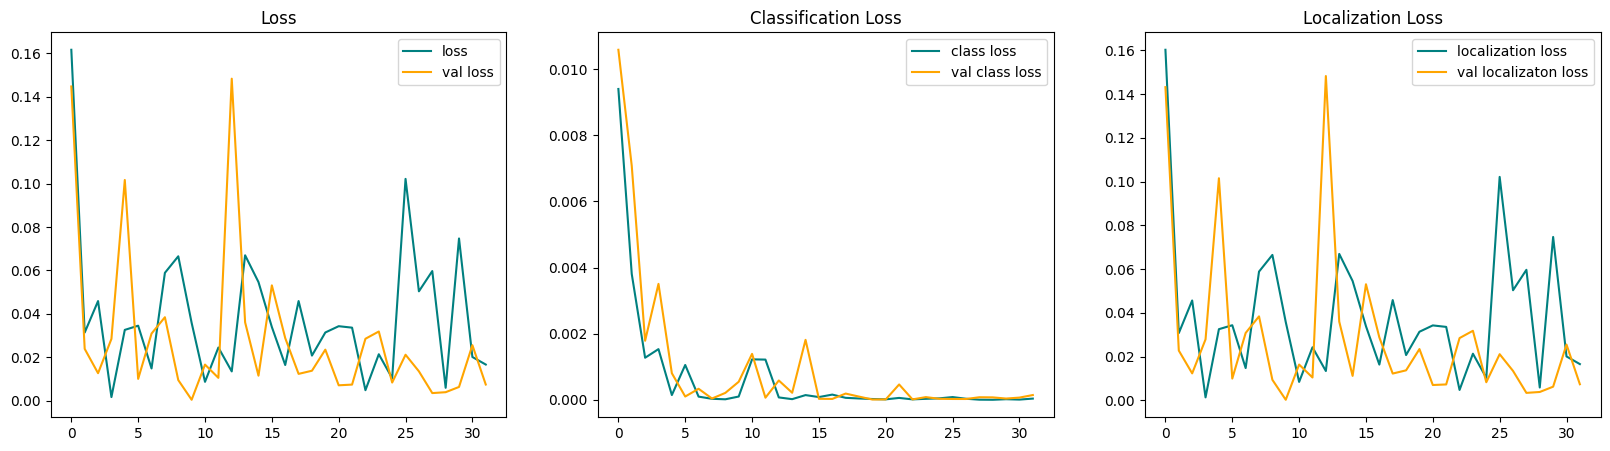

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['localization_loss'], color='teal', label='localization loss')
ax[2].plot(history.history['val_localization_loss'], color='orange', label='val localizaton loss')
ax[2].title.set_text('Localization Loss')
ax[2].legend()

plt.show()

In [16]:
model_tuned.compute_output_shape(input_shape = (None, 256, 256, 3))
model_tuned.save("model_tuned", save_format = "tf")

2023-12-07 17:08:58.562407: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_tuned/assets
